# Churn Rate prediction model

**Autor: Carlos Espadin Medina**

**Carlos.espadin@syngenta.com**

**Caso de estudio:** Syngenta México CP desea predecir el comportamiento del "Churn", cuyo significado es un término común en marketing que se refiere a la tasa de abandono o cancelación de clientes en un negocio o servicio en un período determinado. Este trabajo pretende realizar predicciones de un clasificación binaria que nos inidica si un cliente abanono o no.

## Dependencias

In [1]:
import numpy as np
import pandas as pd


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, RFE, RFECV
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix, classification_report, precision_score, recall_score, f1_score
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
import missingno as msno
import plotly.express as px
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

from varclushi import VarClusHi
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 
import cufflinks as cf

from functools import reduce

cf.go_offline()
pd.set_option('display.max_columns',None)

## Carga de datos

La siguiente información proviene del DataLake de Syngenta y contiene ventas netas de los ultimo 4 años.
*   bp_id : Es el identificador de Business partner o Socio de negocios, nos ayuda a identificar de forma única un cliente.
*   Estado: Entidad federativa registrada del cliente
*   Territorio: Zona comercial, es un dato interno a la compañía, a la cual pertenece el cliente.
*   FechaRegistro: Fecha en que fue registrado el cliente, dado que un cliente se pudo haber registrado más de una vez, se toma la más reciente.
*   Material.Number: Es el identificador de producto comprado con más frecuencia por ese cliente.
*   Temporada: La temporada de compra durante la cual compra con mayor frecuencia el cliente. En este caso contemplamos OI (otoño invierno) y PV (primavera verano)
*   SO: Organización de ventas, es un tipo de división de negocio utilizado internamente en la compañía, los valores son: 3CR (Crop Portection), 3IS (Industy Sales) y 3ST (Seed Treatment)   
*   Linea_Negocio: Tipo de producto, pesticida, herbicida, etc...
*   Date_Last: Ultima fecha de compra
*   Ship_to: Número de bodegas      
*   Devolucion: Número de devoluciones     
*   Volumen: Volumen consumido en unidad de medida de ventas (kg o L)
*   Consumo: Valor total consumido en moneda local (MXP)
*   Frec: Frecuencia de compra.      
*   Venta_2020: Valor total consumido en moneda local (MXP) para el año 2020. 
*   Venta_2021: Valor total consumido en moneda local (MXP) para el año 2021.
*   Venta_2022: Valor total consumido en moneda local (MXP) para el año 2022.
*   Venta_2023: Valor total consumido en moneda local (MXP) para el año 2020.       
*   Crecimiento_21vs20: Crecimiento de las venta del 2020 al 2021, se calcula de la siguiente manera $\frac{Venta_2021}{Venta_2020}-1$
*   Crecimiento_22vs21: Crecimiento de las venta del 2021 al 2022, se calcula de la siguiente manera $\frac{Venta_2022}{Venta_2021}-1$
*   Crecimiento_23vs22: Crecimiento de las venta del 2022 al 2023, se calcula de la siguiente manera $\frac{Venta_2023}{Venta_2022}-1$


In [2]:
datos = pd.read_excel(r'C:\Users\carlo\Syngenta\Projects for Analysis - General\Data processing\Output\Customer_Churn.xlsx')
# datos = pd.read_csv("./Output/Customer_Churn1.csv")
datos

bp_id Estado Territorio FechaRegistro  Material.Number Temporada   SO  \
0    21293987    MIC     A9142O    2019-08-27          1001368        OI  3CR   
1    21107952    VER     A5542E    2017-11-17            24728        OI  3CR   
2    21108647    MOR     A9352B    2017-11-17            55452        OI  3CR   
3    21277503    OAX     A9352E    2019-07-05            25958        OI  3CR   
4    21320909    JAL     A4742A    2019-12-19            39490        OI  3ST   
..        ...    ...        ...           ...              ...       ...  ...   
553  25201116    MIC     A9142A    2023-03-17            13175        OI  3CR   
554  26005072    PUE     A9512E    2023-04-07            13175        OI  3CR   
555  26011524    SIN     A9492D    2023-07-08            27196        OI  3CR   
556  26019912    MIC     A9472J    2023-09-21            72341        OI  3CR   
557  26041032    BCN     A9572B    2024-01-23            39261        OI  3CR   

    Linea_Negocio  Date_Last  Ship_to  Devolucion  Volumen     Consumo  Frec  \
0              FG 2020-01-28        1           0   108.00   237859.48     2   
1              FG 2020-01-30        1           0    24.00    52138.70     2   
2              FG 2020-01-30        1           0  1185.20   247348.89    12   
3              HS 2020-01-30        1           0  1010.00   250934.31     4   
4              ST 2020-01-30        1           0    87.00   307481.26     1   
..            ...        ...      ...         ...      ...         ...   ...   
553            IN 2024-12-03        1           8  2707.00  3105924.97    15   
554            FG 2024-12-03        1           0  1035.20   986696.69    47   
555            IN 2024-12-03        1           1  2430.79  1094863.34    52   
556            NU 2024-12-03        1           2  2259.20   836557.57    48   
557            FG 2024-12-03        1           0   250.80   323877.93     9   

     Venta_2020  Venta_2021  Venta_2022  Venta_2023  Compro  \
0     237859.48         0.0         0.0        0.00       1   
1      52138.70         0.0         0.0        0.00       1   
2     247348.89         0.0         0.0        0.00       1   
3     250934.31         0.0         0.0        0.00       1   
4     307481.26         0.0         0.0        0.00       1   
..          ...         ...         ...         ...     ...   
553        0.00         0.0         0.0  -641163.78       1   
554        0.00         0.0         0.0   662931.39       1   
555        0.00         0.0         0.0   892363.51       1   
556        0.00         0.0         0.0   295280.37       1   
557        0.00         0.0         0.0        0.00       1   

     Crecimiento_21vs20  Crecimiento_22vs21  Crecimiento_23vs22  \
0                  -1.0                 0.0                 0.0   
1                  -1.0                 0.0                 0.0   
2                  -1.0                 0.0                 0.0   
3                  -1.0                 0.0                 0.0   
4                  -1.0                 0.0                 0.0   
..                  ...                 ...                 ...   
553                 0.0                 0.0                 0.0   
554                 0.0                 0.0                 0.0   
555                 0.0                 0.0                 0.0   
556                 0.0                 0.0                 0.0   
557                 0.0                 0.0                 0.0   

     Tiempo_ultima_compra  Anio_Registro  Cliente_Nuevo  Antiguedad  \
0                    1538           2019          False        1692   
1                    1536           2017          False        2340   
2                    1536           2017          False        2340   
3                    1536           2019          False        1745   
4                    1536           2019          False        1578   
..                    ...            ...            ...         ...   
553            

## Análisis Exploratorio de datos

Obtenemos información acerca de los campos del nuetro conjunto de datos.

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   bp_id                 558 non-null    int64         
 1   Estado                558 non-null    object        
 2   Territorio            558 non-null    object        
 3   FechaRegistro         558 non-null    datetime64[ns]
 4   Material.Number       558 non-null    int64         
 5   Temporada             558 non-null    object        
 6   SO                    558 non-null    object        
 7   Linea_Negocio         558 non-null    object        
 8   Date_Last             558 non-null    datetime64[ns]
 9   Ship_to               558 non-null    int64         
 10  Devolucion            558 non-null    int64         
 11  Volumen               558 non-null    float64       
 12  Consumo               558 non-null    float64       
 13  Frec                

In [5]:
datos["y"] = (datos["Churn"]==True).astype(int)

In [6]:
datos.dtypes

bp_id                            int64
Estado                          object
Territorio                      object
FechaRegistro           datetime64[ns]
Material.Number                  int64
Temporada                       object
SO                              object
Linea_Negocio                   object
Date_Last               datetime64[ns]
Ship_to                          int64
Devolucion                       int64
Volumen                        float64
Consumo                        float64
Frec                             int64
Venta_2020                     float64
Venta_2021                     float64
Venta_2022                     float64
Venta_2023                     float64
Compro                           int64
Crecimiento_21vs20             float64
Crecimiento_22vs21             float64
Crecimiento_23vs22             float64
Tiempo_ultima_compra             int64
Anio_Registro                    int64
Cliente_Nuevo                     bool
Antiguedad               

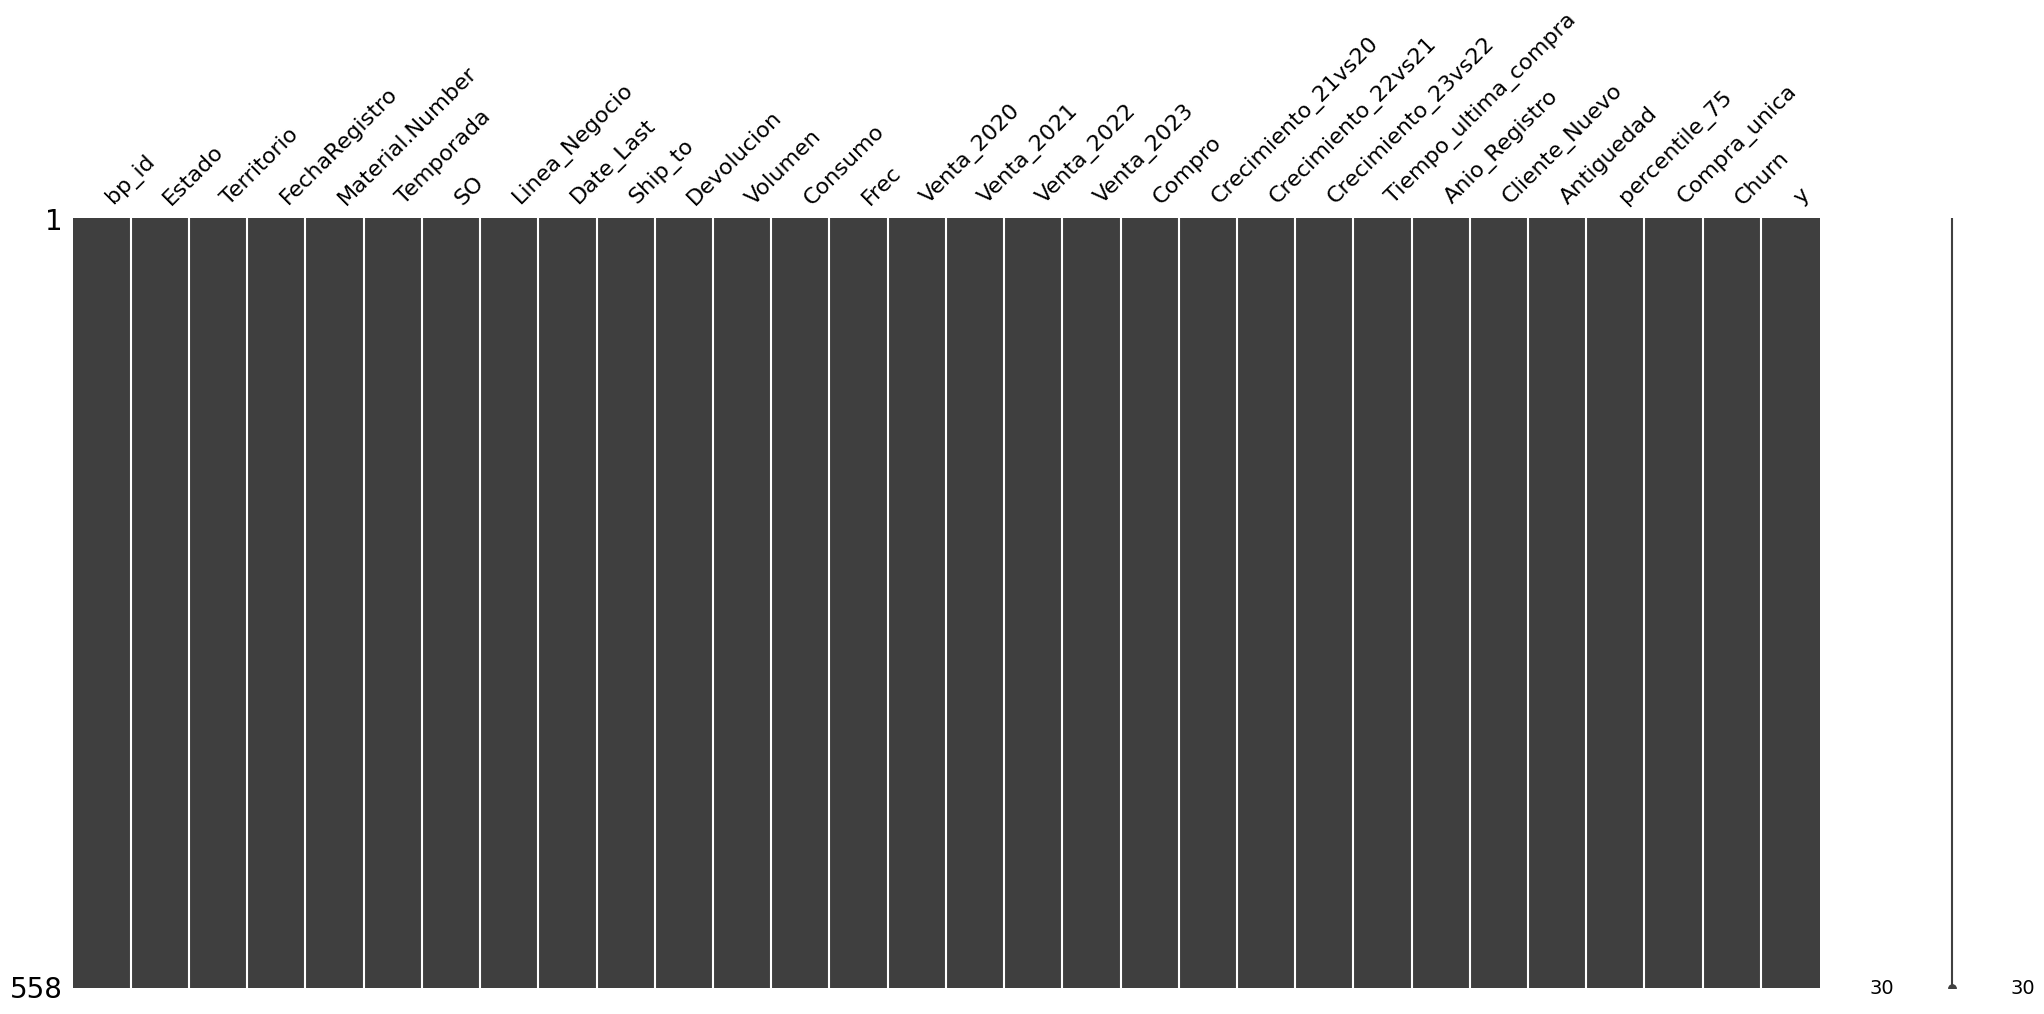

In [7]:
msno.matrix(datos);

In [8]:
datos.tail()

bp_id Estado Territorio FechaRegistro  Material.Number Temporada   SO  \
553  25201116    MIC     A9142A    2023-03-17            13175        OI  3CR   
554  26005072    PUE     A9512E    2023-04-07            13175        OI  3CR   
555  26011524    SIN     A9492D    2023-07-08            27196        OI  3CR   
556  26019912    MIC     A9472J    2023-09-21            72341        OI  3CR   
557  26041032    BCN     A9572B    2024-01-23            39261        OI  3CR   

    Linea_Negocio  Date_Last  Ship_to  Devolucion  Volumen     Consumo  Frec  \
553            IN 2024-12-03        1           8  2707.00  3105924.97    15   
554            FG 2024-12-03        1           0  1035.20   986696.69    47   
555            IN 2024-12-03        1           1  2430.79  1094863.34    52   
556            NU 2024-12-03        1           2  2259.20   836557.57    48   
557            FG 2024-12-03        1           0   250.80   323877.93     9   

     Venta_2020  Venta_2021  Venta_2022  Venta_2023  Compro  \
553         0.0         0.0         0.0  -641163.78       1   
554         0.0         0.0         0.0   662931.39       1   
555         0.0         0.0         0.0   892363.51       1   
556         0.0         0.0         0.0   295280.37       1   
557         0.0         0.0         0.0        0.00       1   

     Crecimiento_21vs20  Crecimiento_22vs21  Crecimiento_23vs22  \
553                 0.0                 0.0                 0.0   
554                 0.0                 0.0                 0.0   
555                 0.0                 0.0                 0.0   
556                 0.0                 0.0                 0.0   
557                 0.0                 0.0                 0.0   

     Tiempo_ultima_compra  Anio_Registro  Cliente_Nuevo  Antiguedad  \
553                   233           2023          False         394   
554                   233           2023          False         373   
555                   233           2023          False         281   
556                   233           2023          False         206   
557                   233           2024           True          82   

     percentile_75  Compra_unica  Churn  y  
553          413.5         False  False  0  
554          413.5         False  False  0  
555          413.5         False  False  0  
556          413.5         False  False  0  
557          413.5         False  False  0

# Data Manipulation

Ahora transformamos la información para su posterior en los algoritmos de ML.

In [9]:
datos['bp_id'] = datos['bp_id'].astype('str')
datos.columns.values

array(['bp_id', 'Estado', 'Territorio', 'FechaRegistro',
       'Material.Number', 'Temporada', 'SO', 'Linea_Negocio', 'Date_Last',
       'Ship_to', 'Devolucion', 'Volumen', 'Consumo', 'Frec',
       'Venta_2020', 'Venta_2021', 'Venta_2022', 'Venta_2023', 'Compro',
       'Crecimiento_21vs20', 'Crecimiento_22vs21', 'Crecimiento_23vs22',
       'Tiempo_ultima_compra', 'Anio_Registro', 'Cliente_Nuevo',
       'Antiguedad', 'percentile_75', 'Compra_unica', 'Churn', 'y'],
      dtype=object)

In [10]:
datos['ID'] = datos['bp_id']
datos['Churn'].value_counts(1)

False    0.749104
True     0.250896
Name: Churn, dtype: float64

## Data Visualization

Distribución de Abandono

In [11]:
import plotly.graph_objects as go

In [12]:
import plotly.graph_objects as go

# Crear un DataFrame con los valores y etiquetas
labels = [False, True]
value_counts = datos['y'].value_counts()
total = len(datos['y'])

# Calcular las proporciones y porcentajes
proportions = value_counts / total
percentages = (value_counts / total) * 100

# Crear una lista de etiquetas personalizada con conteo y porcentaje
custom_labels = [f'{label} ({count}, {percent:.2f}%)' for label, count, percent in zip(labels, value_counts, percentages)]

# Crear la figura
fig = go.Figure(data=[go.Pie(labels=custom_labels, values=proportions, hole=0.5)])

fig.update_traces(
    hoverinfo='label+percent',
    textinfo='label+percent',
    textfont_size=20,
    marker=dict(
        colors=['#ffb300', '#5f7800', '#abb400'],
        line=dict(color='#000000', width=2)
    ),
    pull=[0.1, 0.1]  # Controla la posición de las etiquetas por fuera de la gráfica
)

fig.update_layout(
    title={
        'text': "Distribución de Churn",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    font=dict(
        family="Arial, monospace",
        size=20,
        color="#000000"
    )
)

fig.show()


Clientes nuevos por Churn

In [13]:
# Define el mapeo de colores
color_map = {"Yes": "#5f7800", "No": "#ffb300"}

# Crea el histograma
fig = px.histogram(
    datos, 
    x="y", 
    color="Cliente_Nuevo", 
    barmode="group", 
    title="<b>Distribución de Cliente Nuevo</b>"
)

# Ajusta el ancho, alto y espacio entre las barras
fig.update_layout(width=700, height=500, bargap=0.1)

# Cambia el nombre del eje x a "Churn"
fig.update_xaxes(title_text="Churn")

# Cambia los colores de las barras y agrega contornos negros
fig.update_traces(
    marker=dict(color=[color_map[value] for value in color_map], line=dict(color="black", width=2))
)

# Muestra el gráfico
fig.show()


Distribución de Clientes que compraron una sola vez:

In [14]:
# color_map = {1: "#FF97FF", 0: "#AB63FA"}
# fig = px.histogram(datos, x="y", color="Compra_unica", title="<b>Distribución de Clientes que compraron solo una vez</b>", color_discrete_map=color_map)
# fig.update_layout(width=700, height=500, bargap=0.1)
# fig.show()

La distribución de antiguedad por bp_id

C:\Users\carlo\AppData\Local\Temp\ipykernel_26828\235660633.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\carlo\AppData\Local\Temp\ipykernel_26828\235660633.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




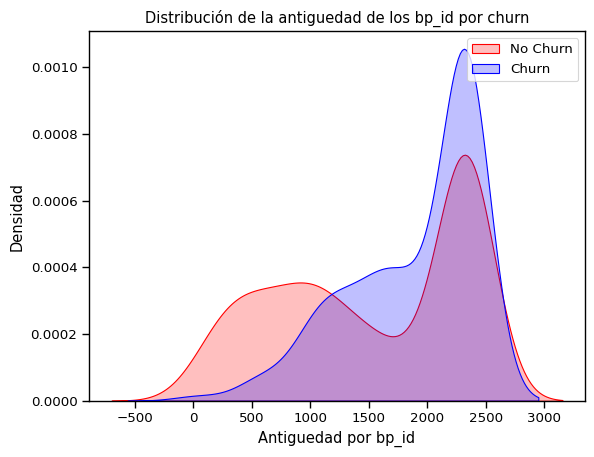

In [15]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(datos.Antiguedad[(datos["y"] == 0) ],
                color="Red", shade = True);
ax = sns.kdeplot(datos.Antiguedad[(datos["y"] == 1) ],
                ax =ax, color="Blue", shade= True);
ax.legend(["No Churn","Churn"],loc='upper right');
ax.set_ylabel('Densidad');
ax.set_xlabel('Antiguedad por bp_id');
ax.set_title('Distribución de la antiguedad de los bp_id por churn');

Creamos los vectores de variables continuas y categoricas

In [16]:
datos['Anio_Registro'] = datos['Anio_Registro'].astype('str')
datos.columns.values

array(['bp_id', 'Estado', 'Territorio', 'FechaRegistro',
       'Material.Number', 'Temporada', 'SO', 'Linea_Negocio', 'Date_Last',
       'Ship_to', 'Devolucion', 'Volumen', 'Consumo', 'Frec',
       'Venta_2020', 'Venta_2021', 'Venta_2022', 'Venta_2023', 'Compro',
       'Crecimiento_21vs20', 'Crecimiento_22vs21', 'Crecimiento_23vs22',
       'Tiempo_ultima_compra', 'Anio_Registro', 'Cliente_Nuevo',
       'Antiguedad', 'percentile_75', 'Compra_unica', 'Churn', 'y', 'ID'],
      dtype=object)

In [17]:
vard = ['Territorio',
        'Estado',
        'Cliente_Nuevo',
        'Anio_Registro',
        'Compra_unica',
        'Material.Number',
        'Temporada',
        'SO',
        'Linea_Negocio'
    ]

varc = [
            'Antiguedad',
            'Volumen',
            'Consumo',
            # 'N_Material',
            'Ship_to',
            'Frec',
            'Tiempo_ultima_compra',
            'Devolucion',
            'Venta_2020',
            'Venta_2021',
            'Venta_2022',
            'Venta_2023',
            'Crecimiento_21vs20',
            'Crecimiento_22vs21',
            'Crecimiento_23vs22'
    ]

vart = ['y']
um = ['ID']

In [18]:
datos = datos[um+vart+varc+vard]

Distribución de cada una de las variables numericas para el modelo.

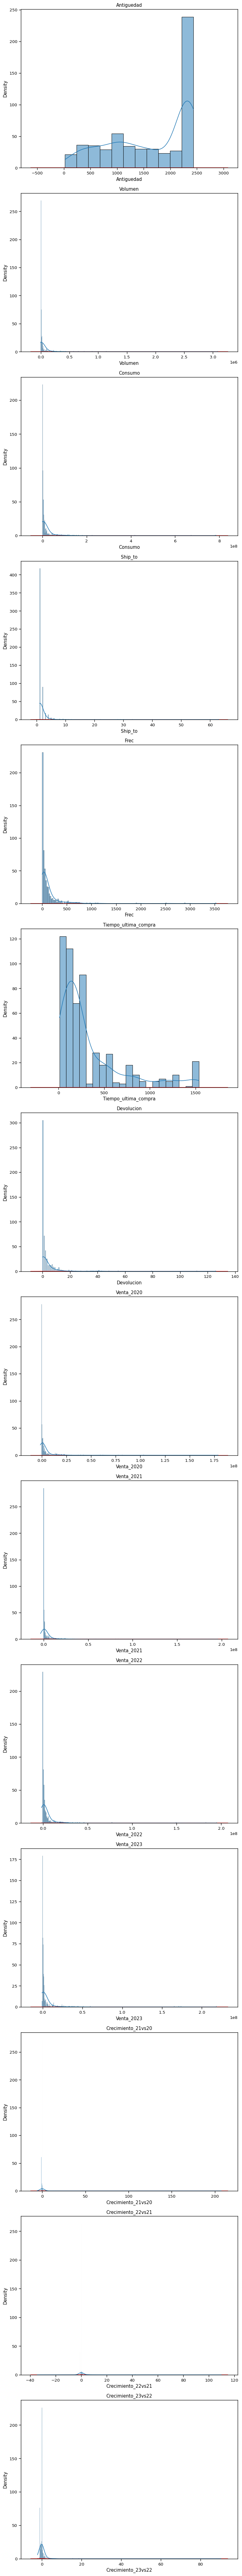

In [19]:
fig, axes = plt.subplots(len(varc), 1, figsize=(8, 6*len(varc)))

for i, feat in enumerate(varc):
    ax = axes[i]
    sns.kdeplot(datos[feat], ax=ax, color='red')
    sns.histplot(datos[feat], ax=ax, kde=True)
    ax.set_title(feat)

plt.tight_layout()
plt.show()

¿Los nuevos clientes son más propensos a abandonar?

In [20]:
plt.figure(figsize=(25, 10))

corr = datos.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [21]:
correlation_matrix = datos.corr()
correlation_matrix['names'] = correlation_matrix.index

C:\Users\carlo\AppData\Local\Temp\ipykernel_26828\3867558022.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [22]:
correlation_matrix

y  Antiguedad   Volumen   Consumo   Ship_to  \
y                     1.000000    0.205155 -0.103122 -0.128785 -0.053820   
Antiguedad            0.205155    1.000000  0.120962  0.163327  0.091905   
Volumen              -0.103122    0.120962  1.000000  0.789099  0.520242   
Consumo              -0.128785    0.163327  0.789099  1.000000  0.673209   
Ship_to              -0.053820    0.091905  0.520242  0.673209  1.000000   
Frec                 -0.188902    0.175405  0.605057  0.810812  0.720989   
Tiempo_ultima_compra  0.841768    0.230470 -0.074616 -0.080488 -0.012751   
Devolucion           -0.135738    0.060436  0.304882  0.584895  0.578638   
Venta_2020           -0.088597    0.201211  0.595680  0.905161  0.719505   
Venta_2021           -0.129433    0.174080  0.654719  0.944628  0.712732   
Venta_2022           -0.134210    0.160147  0.711581  0.970661  0.698079   
Venta_2023           -0.137503    0.126803  0.870753  0.968995  0.654515   
Crecimiento_21vs20    0.057233    0.044805  0.003102  0.000623  0.008632   
Crecimiento_22vs21   -0.096783    0.019377 -0.000322  0.000434  0.002442   
Crecimiento_23vs22   -0.092758    0.024261  0.100764  0.117800  0.043644   
Cliente_Nuevo        -0.028089   -0.231683 -0.024031 -0.028270 -0.023535   
Compra_unica         -0.008468   -0.126427 -0.028452 -0.033371 -0.026734   
Material.Number       0.048236    0.046186  0.020745  0.126114  0.039556   

                          Frec  Tiempo_ultima_compra  Devolucion  Venta_2020  \
y                    -0.188902              0.841768   -0.135738   -0.088597   
Antiguedad            0.175405              0.230470    0.060436    0.201211   
Volumen               0.605057             -0.074616    0.304882    0.595680   
Consumo               0.810812             -0.080488    0.584895    0.905161   
Ship_to               0.720989             -0.012751    0.578638    0.719505   
Frec                  1.000000             -0.128706    0.718609    0.858981   
Tiempo_ultima_compra -0.128706              1.000000   -0.101512   -0.031649   
Devolucion            0.718609             -0.101512    1.000000    0.699829   
Venta_2020            0.858981             -0.031649    0.699829    1.000000   
Venta_2021            0.861965             -0.085848    0.662165    0.919522   
Venta_2022            0.813848             -0.093431    0.587313    0.892393   
Venta_2023            0.785852             -0.089967    0.514122    0.812454   
Crecimiento_21vs20   -0.005482              0.077165    0.011370   -0.013264   
Crecimiento_22vs21    0.016969             -0.084770    0.028698    0.025569   
Crecimiento_23vs22    0.021701             -0.051455    0.019975    0.010203   
Cliente_Nuevo        -0.039339             -0.058175   -0.037810   -0.030095   
Compra_unica         -0.051990             -0.022639    0.044976   -0.034187   
Material.Number       0.173412              0.068516    0.163655    0.153938   

                      Venta_2021  Venta_2022  Venta_2023  Crecimiento_21vs20  \
y                      -0.129433   -0.134210   -0.137503            0.057233   
Antiguedad              0.174080    0.160147    0.126803            0.044805   
Volumen                 0.654719    0.711581    0.870753            0.003102   
Consumo                 0.944628    0.970661    0.968995            0.000623   
Ship_to                 0.712732    0.698079    0.654515            0.008632   
Frec                    0.861965    0.813848    0.785852           -0.005482   
Tiempo_ultima_compra   -0.085848   -0.093431   -0.089967            0.077165   
Devolucion              0.662165    0.587313    0.514122            0.011370   
Venta_2020              0.919522    0.892393    0.812454           -0.013264   
Venta_2021              1.000000    0.939468    0.884216            0.013619   
Venta_2022              0.939468    1.000000    0.919864           -0.006133   
Venta_2023              0.884216    0.919864    1.000000            0.003103   
Crecimiento_21vs20     

In [23]:
correlation_matrix.to_excel('C:\\Users\\carlo\\OneDrive\\Documents\\Python Scripts Last Version\\Analytics\\Beta v2.0\\Output\\Correlaciones.xlsx', index=False) 

## Preparación de los datos.

### Dividir los datos en conjunto de entrenamiento y conjunto de prueba

In [24]:
train, valid = train_test_split(datos,train_size=0.7)
train.reset_index(drop=True,inplace=True),valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((390, 25), (168, 25))

In [25]:
# # Normalizar las variables numéricas en el conjunto de entrenamiento
# scaler = MinMaxScaler()
# train[varc] = scaler.fit_transform(train[varc])

# # Aplicar la misma normalización a las variables numéricas en el conjunto de prueba
# valid[varc] = scaler.transform(valid[varc])


## Reducción de dimensiones.

In [26]:
varclus = VarClusHi(df=train,feat_list=varc).varclus()
varclus.varclus()

In [27]:
varclus.rsquare

Cluster              Variable    RS_Own     RS_NC  RS_Ratio
0         0               Volumen  0.676048  0.010423  0.327364
1         0               Consumo  0.918499  0.020143  0.083177
2         0               Ship_to  0.712201  0.002215  0.288438
3         0                  Frec  0.765508  0.000512  0.234613
4         0            Devolucion  0.399471  0.004097  0.603000
5         0            Venta_2020  0.894534  0.004619  0.105956
6         0            Venta_2021  0.924182  0.050825  0.079878
7         0            Venta_2022  0.894998  0.000186  0.105021
8         0            Venta_2023  0.879351  0.033174  0.124789
9         1            Antiguedad  0.452877  0.020697  0.558686
10        1  Tiempo_ultima_compra  0.582318  0.009960  0.421884
11        1    Crecimiento_21vs20  0.157370  0.001844  0.844187
12        1    Crecimiento_22vs21  0.127645  0.000624  0.872900
13        2    Crecimiento_23vs22  1.000000  0.009417  0.000000

In [28]:
var = list(varclus.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])
len(var)

3

In [29]:
var

['Venta_2021', 'Tiempo_ultima_compra', 'Crecimiento_23vs22']

## Analisis Univariado
### Continuo

array([[<Axes: title={'center': 'Venta_2021'}>,
        <Axes: title={'center': 'Tiempo_ultima_compra'}>],
       [<Axes: title={'center': 'Crecimiento_23vs22'}>, <Axes: >]],
      dtype=object)

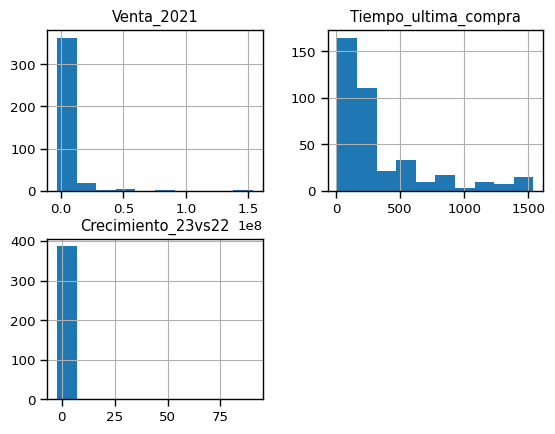

In [30]:
train[var].hist()

#### Ausentes

In [31]:
(train[var].isna().sum()/len(train)).to_frame()

0
Venta_2021            0.0
Tiempo_ultima_compra  0.0
Crecimiento_23vs22    0.0

#### Extremos.

In [32]:
for v,li,ls in train[var].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)

In [33]:
train['ex_'] = train.filter(like='ex_').max(axis=1)

In [34]:
train['ex_'].value_counts(1)

0    0.94359
1    0.05641
Name: ex_, dtype: float64

In [35]:
train = train[train['ex_']==0].reset_index(drop=True)

In [36]:
train.drop(train.filter(like='ex_').columns,axis=1,inplace=True)

In [37]:
train[var].hist(figsize=(7,7))

array([[<Axes: title={'center': 'Venta_2021'}>,
        <Axes: title={'center': 'Tiempo_ultima_compra'}>],
       [<Axes: title={'center': 'Crecimiento_23vs22'}>, <Axes: >]],
      dtype=object)

In [38]:
train[var].describe(percentiles=[0.01,0.05,0.95,0.99])

Venta_2021  Tiempo_ultima_compra  Crecimiento_23vs22
count  3.680000e+02            368.000000          368.000000
mean   2.417564e+06            321.290761           -0.047311
std    5.597376e+06            360.025960            0.911290
min    0.000000e+00             17.000000           -1.153162
1%     0.000000e+00             18.000000           -1.004763
5%     0.000000e+00             18.000000           -1.000000
50%    2.159108e+05            190.500000            0.000000
95%    1.322244e+07           1248.500000            1.440355
99%    2.496992e+07           1483.980000            4.232231
max    4.813665e+07           1508.000000            6.330727

### Discreto.
#### Analisis de frecuencia.

In [39]:
def freq(data:pd.DataFrame,variables:list):
    if type(variables) is not list:
        variables = [variables]
    for v in variables:
        aux = data[v].value_counts().to_frame()
        aux.rename(columns={v:'FA'},inplace=True)
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.cumsum()
        print(f"Tabla de frecuencias de la variable **{v}**\n\n")
        print(aux)
        print("\n")

In [40]:
print(pd.__version__)

1.5.3


In [41]:
freq(train,vard)

Tabla de frecuencias de la variable **Territorio**


        FA        FR  FAA       FRA
A5842A  17  0.046196   17  0.046196
A4A42A   9  0.024457   26  0.070652
A4742A   8  0.021739   34  0.092391
A9582F   7  0.019022   41  0.111413
A9482C   7  0.019022   48  0.130435
...     ..       ...  ...       ...
A5742L   1  0.002717  364  0.989130
A9142K   1  0.002717  365  0.991848
A9442H   1  0.002717  366  0.994565
A9482A   1  0.002717  367  0.997283
A9142N   1  0.002717  368  1.000000

[148 rows x 4 columns]


Tabla de frecuencias de la variable **Estado**


     FA        FR  FAA       FRA
JAL  43  0.116848   43  0.116848
MIC  40  0.108696   83  0.225543
CHP  29  0.078804  112  0.304348
GUA  24  0.065217  136  0.369565
SIN  22  0.059783  158  0.429348
PUE  18  0.048913  176  0.478261
TAM  18  0.048913  194  0.527174
MEX  17  0.046196  211  0.573370
COA  16  0.043478  227  0.616848
CAM  15  0.040761  242  0.657609
ZAC  11  0.029891  253  0.687500
BCN   9  0.024457  262  0.711957
HID   9  0.

#### Normalización

In [42]:
def normalizar(df:pd.DataFrame,var:str,umbral:float=0.05)->tuple:
    """Esta función normaliza una variable discreta basada en el 
    principio de umbral de representatividad estadística.

    Args:
        df (pd.DataFrame): datos con v.d. a normalizar
        var (str): nombre de la variable
        umbral (float, optional): umbral estadístico deseado. Defaults to 0.05.

    Returns:
        tuple: nombre de la variable y mapa de normalización
    """
    aux = df[var].value_counts(1).to_frame()
    aux['map'] = np.where(aux[var]<umbral,'Otros',aux.index)
    if aux.loc[aux['map']=='Otros'][var].sum()<umbral:
        aux['map'].replace({'Otros':aux.head(1)['map'].values[0]},inplace=True)
    aux.drop(var,axis=1,inplace=True)
    return var,aux['map'].to_dict()

In [43]:
print(train.columns.values)

['ID' 'y' 'Antiguedad' 'Volumen' 'Consumo' 'Ship_to' 'Frec'
 'Tiempo_ultima_compra' 'Devolucion' 'Venta_2020' 'Venta_2021'
 'Venta_2022' 'Venta_2023' 'Crecimiento_21vs20' 'Crecimiento_22vs21'
 'Crecimiento_23vs22' 'Territorio' 'Estado' 'Cliente_Nuevo'
 'Anio_Registro' 'Compra_unica' 'Material.Number' 'Temporada' 'SO'
 'Linea_Negocio']


In [44]:
type(train[vard])

pandas.core.frame.DataFrame

In [45]:
type(pd.Index(vard))

pandas.core.indexes.base.Index

In [46]:
list(map(lambda v: print(train.columns.values, "-", v), pd.Index(vard)))

['ID' 'y' 'Antiguedad' 'Volumen' 'Consumo' 'Ship_to' 'Frec'
 'Tiempo_ultima_compra' 'Devolucion' 'Venta_2020' 'Venta_2021'
 'Venta_2022' 'Venta_2023' 'Crecimiento_21vs20' 'Crecimiento_22vs21'
 'Crecimiento_23vs22' 'Territorio' 'Estado' 'Cliente_Nuevo'
 'Anio_Registro' 'Compra_unica' 'Material.Number' 'Temporada' 'SO'
 'Linea_Negocio'] - Territorio
['ID' 'y' 'Antiguedad' 'Volumen' 'Consumo' 'Ship_to' 'Frec'
 'Tiempo_ultima_compra' 'Devolucion' 'Venta_2020' 'Venta_2021'
 'Venta_2022' 'Venta_2023' 'Crecimiento_21vs20' 'Crecimiento_22vs21'
 'Crecimiento_23vs22' 'Territorio' 'Estado' 'Cliente_Nuevo'
 'Anio_Registro' 'Compra_unica' 'Material.Number' 'Temporada' 'SO'
 'Linea_Negocio'] - Estado
['ID' 'y' 'Antiguedad' 'Volumen' 'Consumo' 'Ship_to' 'Frec'
 'Tiempo_ultima_compra' 'Devolucion' 'Venta_2020' 'Venta_2021'
 'Venta_2022' 'Venta_2023' 'Crecimiento_21vs20' 'Crecimiento_22vs21'
 'Crecimiento_23vs22' 'Territorio' 'Estado' 'Cliente_Nuevo'
 'Anio_Registro' 'Compra_unica' 'Material.Number' 'T

[None, None, None, None, None, None, None, None, None]

In [47]:
mapa_norm = list(map(lambda v: normalizar(train, v), pd.Index(vard)))

In [48]:
for v, mapa in mapa_norm:
    train[f'n_{v}'] = train[v].replace(mapa)

In [49]:
varn = [v for v in train.columns if v[:2]=='n_']

In [50]:
train

ID  y  Antiguedad     Volumen      Consumo  Ship_to  Frec  \
0    21352679  0        1334    1248.600    297554.20        1    12   
1    21107556  0        2340  176061.840  54744500.77        3    96   
2    21247649  1        2061   55062.999   7550717.12        4    75   
3    21481879  0        1056     268.000    169759.11        1     4   
4    21216509  0        2081  366147.028  80960683.58        6   246   
..        ... ..         ...         ...          ...      ...   ...   
363  21107464  0        2340   93641.150  53962112.93        2   578   
364  21107551  0        2340  398719.200  60638560.54        8   151   
365  21109163  0        2340   14133.400  13459622.79        1    58   
366  21154581  0        2312    7652.320   8184415.05        3   343   
367  21518765  0         945     241.960    433422.54        1    31   

     Tiempo_ultima_compra  Devolucion   Venta_2020   Venta_2021   Venta_2022  \
0                      18           0         0.00    203423.67         0.00   
1                     111           0   7297922.50  14704033.90  14578784.08   
2                     925           1   1562415.42   5988301.70         0.00   
3                     224           0         0.00         0.00         0.00   
4                      18          15  15454695.54  23565830.90  18345149.32   
..                    ...         ...          ...          ...          ...   
363                   201          12  11557483.32   9533667.26  14613545.53   
364                   111           3   9175713.49  26592595.82   8332764.68   
365                   141           2   2167883.68   3709204.11   5223748.39   
366                   110           2    935532.26   1700772.90   2515490.06   
367                   232           9         0.00         0.00         0.00   

      Venta_2023  Crecimiento_21vs20  Crecimiento_22vs21  Crecimiento_23vs22  \
0           0.00            0.000000           -1.000000            0.000000   
1    12050992.18            1.014825           -0.008518           -0.173388   
2           0.00            2.832721           -1.000000            0.000000   
3      169759.11            0.000000            0.000000            0.000000   
4     4451023.58            0.524833           -0.221536           -0.757373   
..           ...                 ...                 ...                 ...   
363  11974845.60           -0.175109            0.532836           -0.180565   
364  14031800.63            1.898150           -0.686651            0.683931   
365   1940737.62            0.710979            0.408321           -0.628478   
366   2237616.93            0.817974            0.479028           -0.110465   
367    408547.68            0.000000            0.000000            0.000000   

    Territorio Estado  Cliente_Nuevo Anio_Registro  Compra_unica  \
0       A5542O    VER          False          2020         False   
1       A9582B    TAM          False          2017         False   
2       A5442F    MEX          False          2018         False   
3       A9512E    PUE          False          2021         False   
4       A5742J    ZAC          False          2018         False   
..         ...    ...            ...           ...           ...   
363     A9252A    QUE          False          2017         False   
364     A9482F    TAB          False          2017         False   
365     A9492A    SIN          False          2017         False   
366     A5442D    MEX          False          2017         False   
367     A9472L    MIC          False          2021         False   

     Material.Number Temporada   SO Linea_Negocio n_Territorio n_Estado  \
0              32732        OI  3CR            FG        Otros    Otros   
1              26867        OI  3CR            HS        Otros    Otros   
2            1001368        OI  3CR            FG        Otros    Otros   
3              44976        OI  3CR            FG        Otros    Otros   
4              32713        OI  

In [51]:
freq(train,varn)

Tabla de frecuencias de la variable **n_Territorio**


        FA   FR  FAA  FRA
Otros  368  1.0  368  1.0


Tabla de frecuencias de la variable **n_Estado**


        FA        FR  FAA       FRA
Otros  210  0.570652  210  0.570652
JAL     43  0.116848  253  0.687500
MIC     40  0.108696  293  0.796196
CHP     29  0.078804  322  0.875000
GUA     24  0.065217  346  0.940217
SIN     22  0.059783  368  1.000000


Tabla de frecuencias de la variable **n_Cliente_Nuevo**


        FA   FR  FAA  FRA
False  368  1.0  368  1.0


Tabla de frecuencias de la variable **n_Anio_Registro**


       FA        FR  FAA       FRA
2017  167  0.453804  167  0.453804
2021   57  0.154891  224  0.608696
2022   34  0.092391  258  0.701087
2023   33  0.089674  291  0.790761
2020   28  0.076087  319  0.866848
2019   28  0.076087  347  0.942935
2018   21  0.057065  368  1.000000


Tabla de frecuencias de la variable **n_Compra_unica**


        FA   FR  FAA  FRA
False  368  1.0  368  1.0


Tabla de frecuencias de

#### Quitar Unarias (Sin varianza)

In [52]:
unarias = [v for v in varn if train[v].nunique()==1]

In [53]:
unarias

['n_Territorio', 'n_Cliente_Nuevo', 'n_Compra_unica', 'n_Temporada']

In [54]:
varn = [v for v in varn if v not in unarias]

In [55]:
train.drop(unarias,axis=1,inplace=True)

In [56]:
len(varn)

5

In [57]:
varn

['n_Estado', 'n_Anio_Registro', 'n_Material.Number', 'n_SO', 'n_Linea_Negocio']

# Representación Vectorial.

In [58]:
oh = OneHotEncoder(drop='if_binary',sparse_output=False, handle_unknown='ignore')

In [59]:
oh.fit(train[varn])

OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [60]:
var_dummy = list(oh.get_feature_names_out())

In [61]:
train[var_dummy] = oh.transform(train[varn])

In [62]:
len(var+var_dummy)

23

array([[<Axes: title={'center': 'Venta_2021'}>,
        <Axes: title={'center': 'Tiempo_ultima_compra'}>,
        <Axes: title={'center': 'Crecimiento_23vs22'}>,
        <Axes: title={'center': 'n_Estado_CHP'}>,
        <Axes: title={'center': 'n_Estado_GUA'}>],
       [<Axes: title={'center': 'n_Estado_JAL'}>,
        <Axes: title={'center': 'n_Estado_MIC'}>,
        <Axes: title={'center': 'n_Estado_Otros'}>,
        <Axes: title={'center': 'n_Estado_SIN'}>,
        <Axes: title={'center': 'n_Anio_Registro_2017'}>],
       [<Axes: title={'center': 'n_Anio_Registro_2018'}>,
        <Axes: title={'center': 'n_Anio_Registro_2019'}>,
        <Axes: title={'center': 'n_Anio_Registro_2020'}>,
        <Axes: title={'center': 'n_Anio_Registro_2021'}>,
        <Axes: title={'center': 'n_Anio_Registro_2022'}>],
       [<Axes: title={'center': 'n_Anio_Registro_2023'}>,
        <Axes: title={'center': 'n_Material.Number_Otros'}>,
        <Axes: title={'center': 'n_SO_Otros'}>,
        <Axes: tit

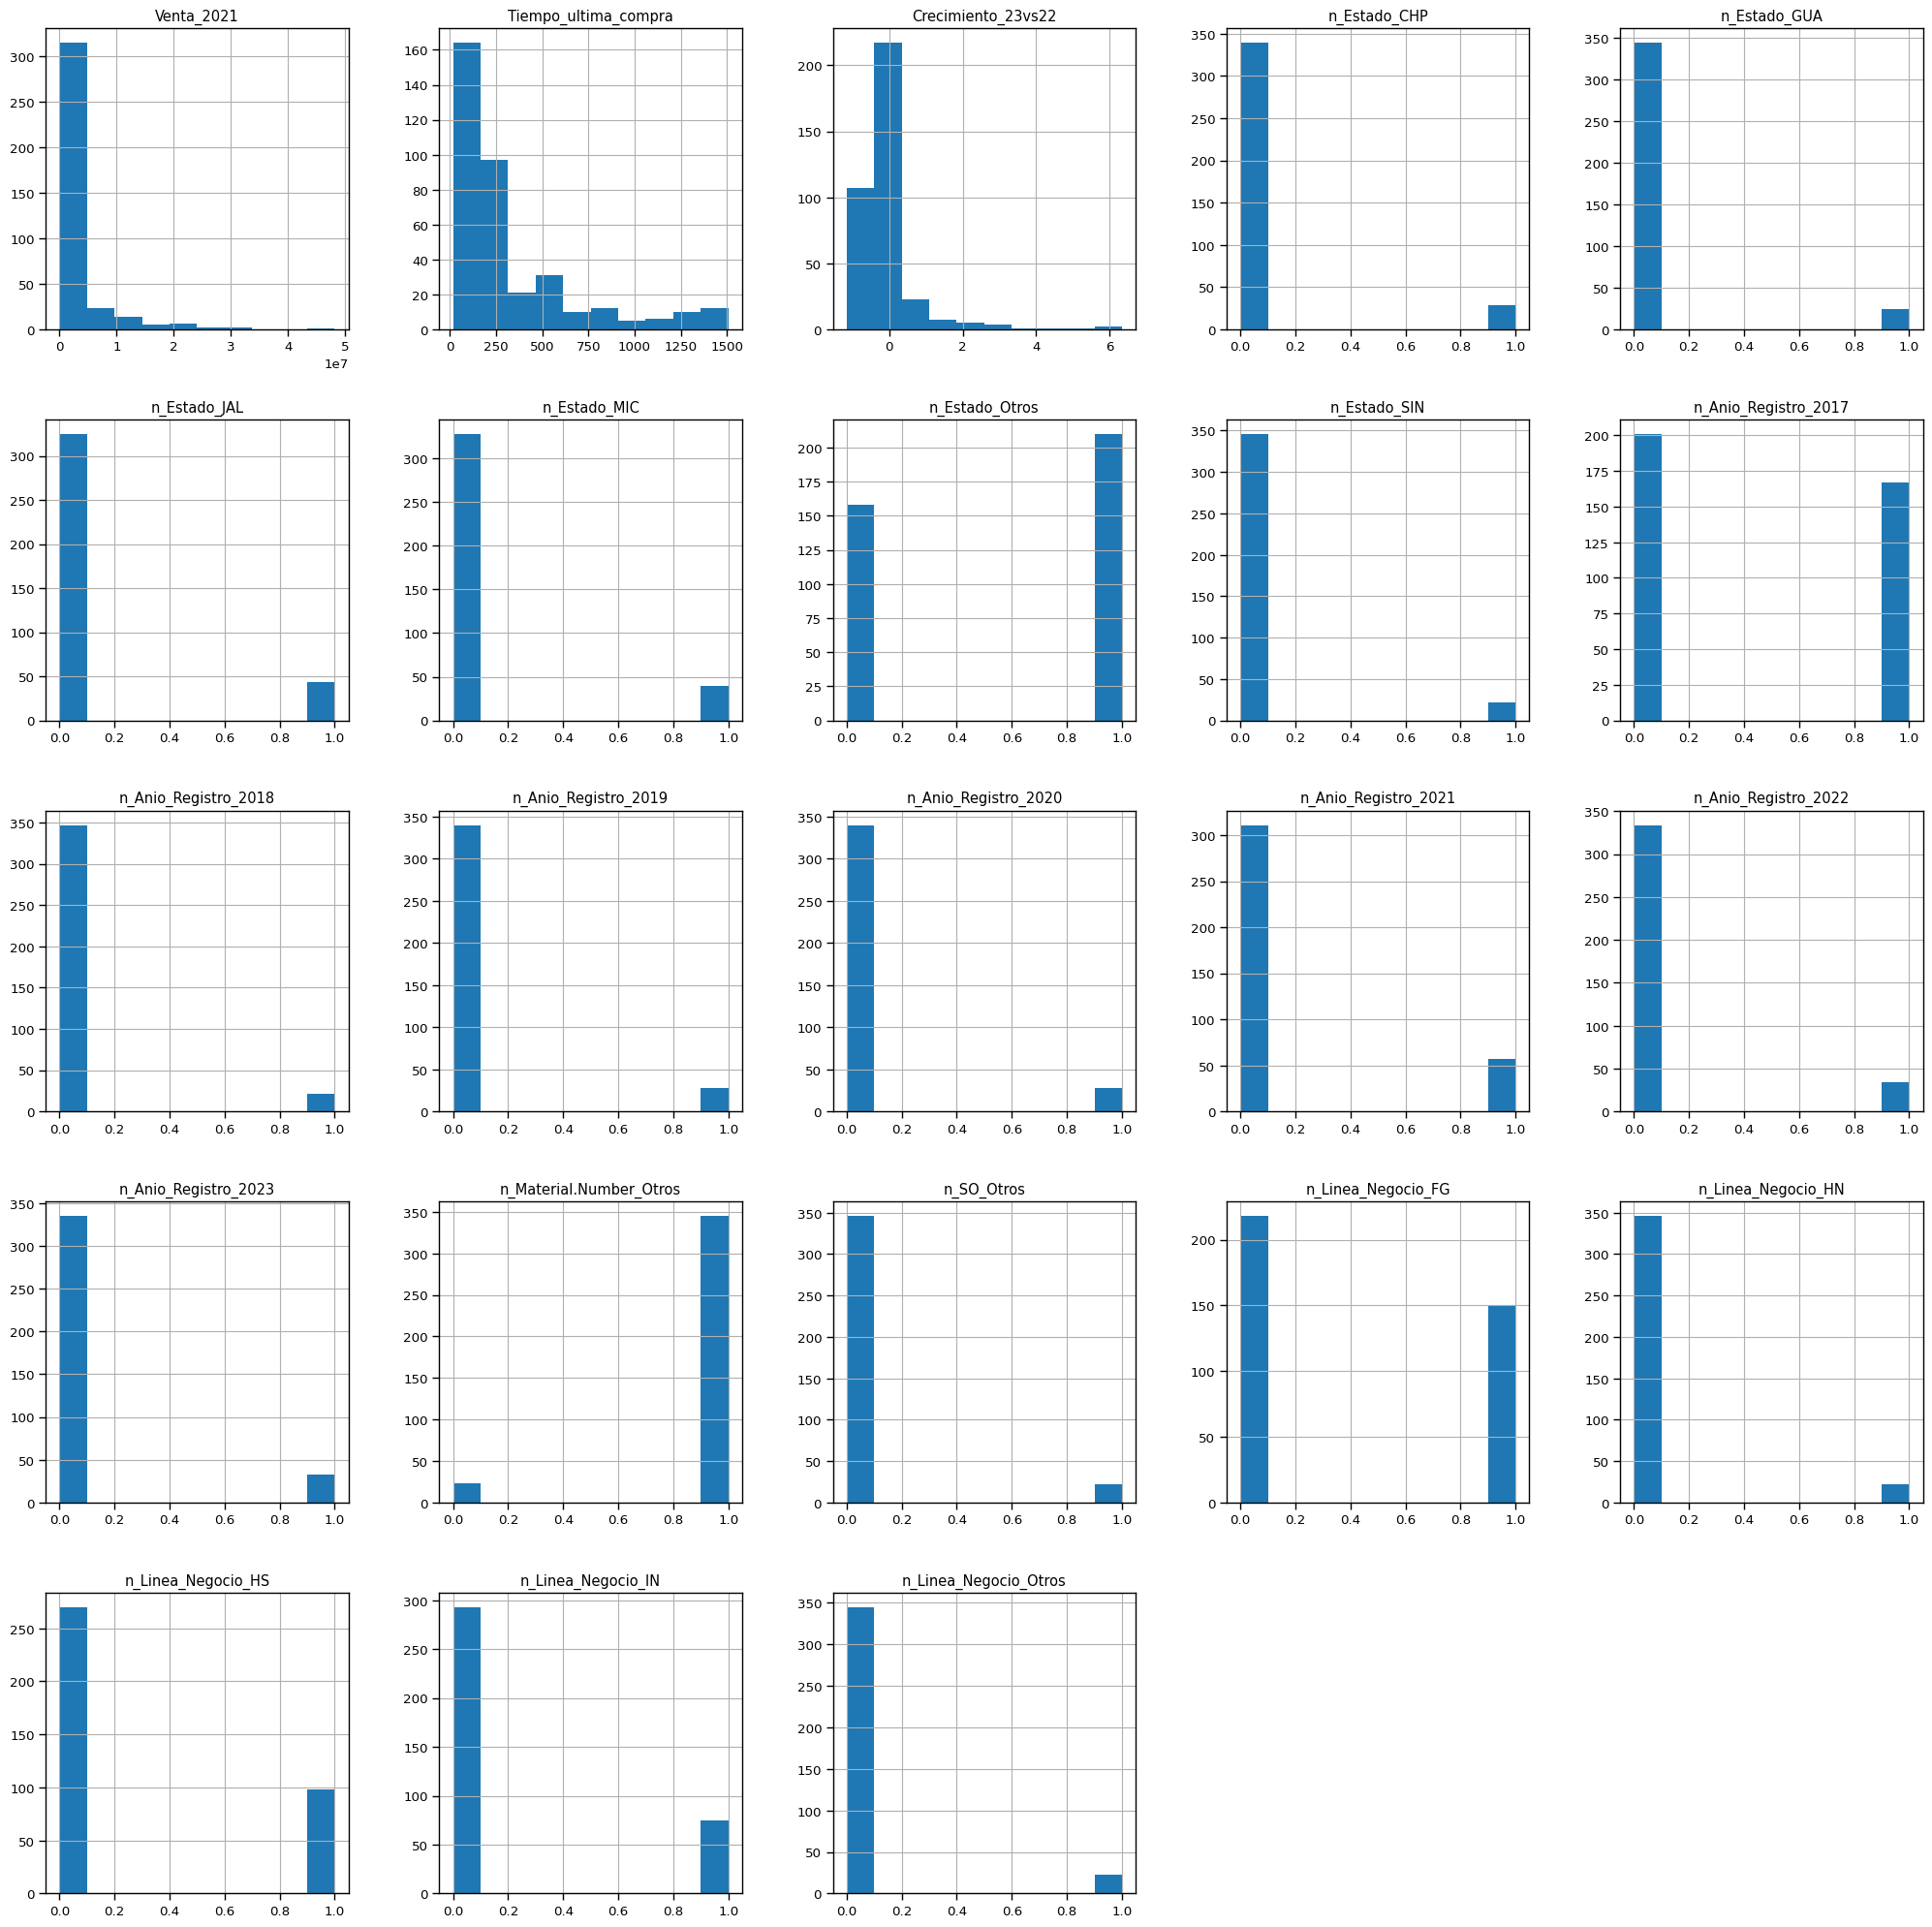

In [63]:
train[var+var_dummy].hist(figsize=(25,25))

# Análisis de poder predictivo

In [64]:
#sk = SelectKBest(k=len(var+var_dummy))
sk = SelectKBest(k=9)

In [65]:
sk.fit(train[var+var_dummy], train['y'])

SelectKBest(k=9)

In [66]:
pd.Series(dict(zip(sk.get_feature_names_out(),sk.scores_))).sort_values(ascending=False).iplot(kind='bar',color='purple')

In [67]:
best = [v for v,d in zip(var+var_dummy,sk.get_support()) if d ]

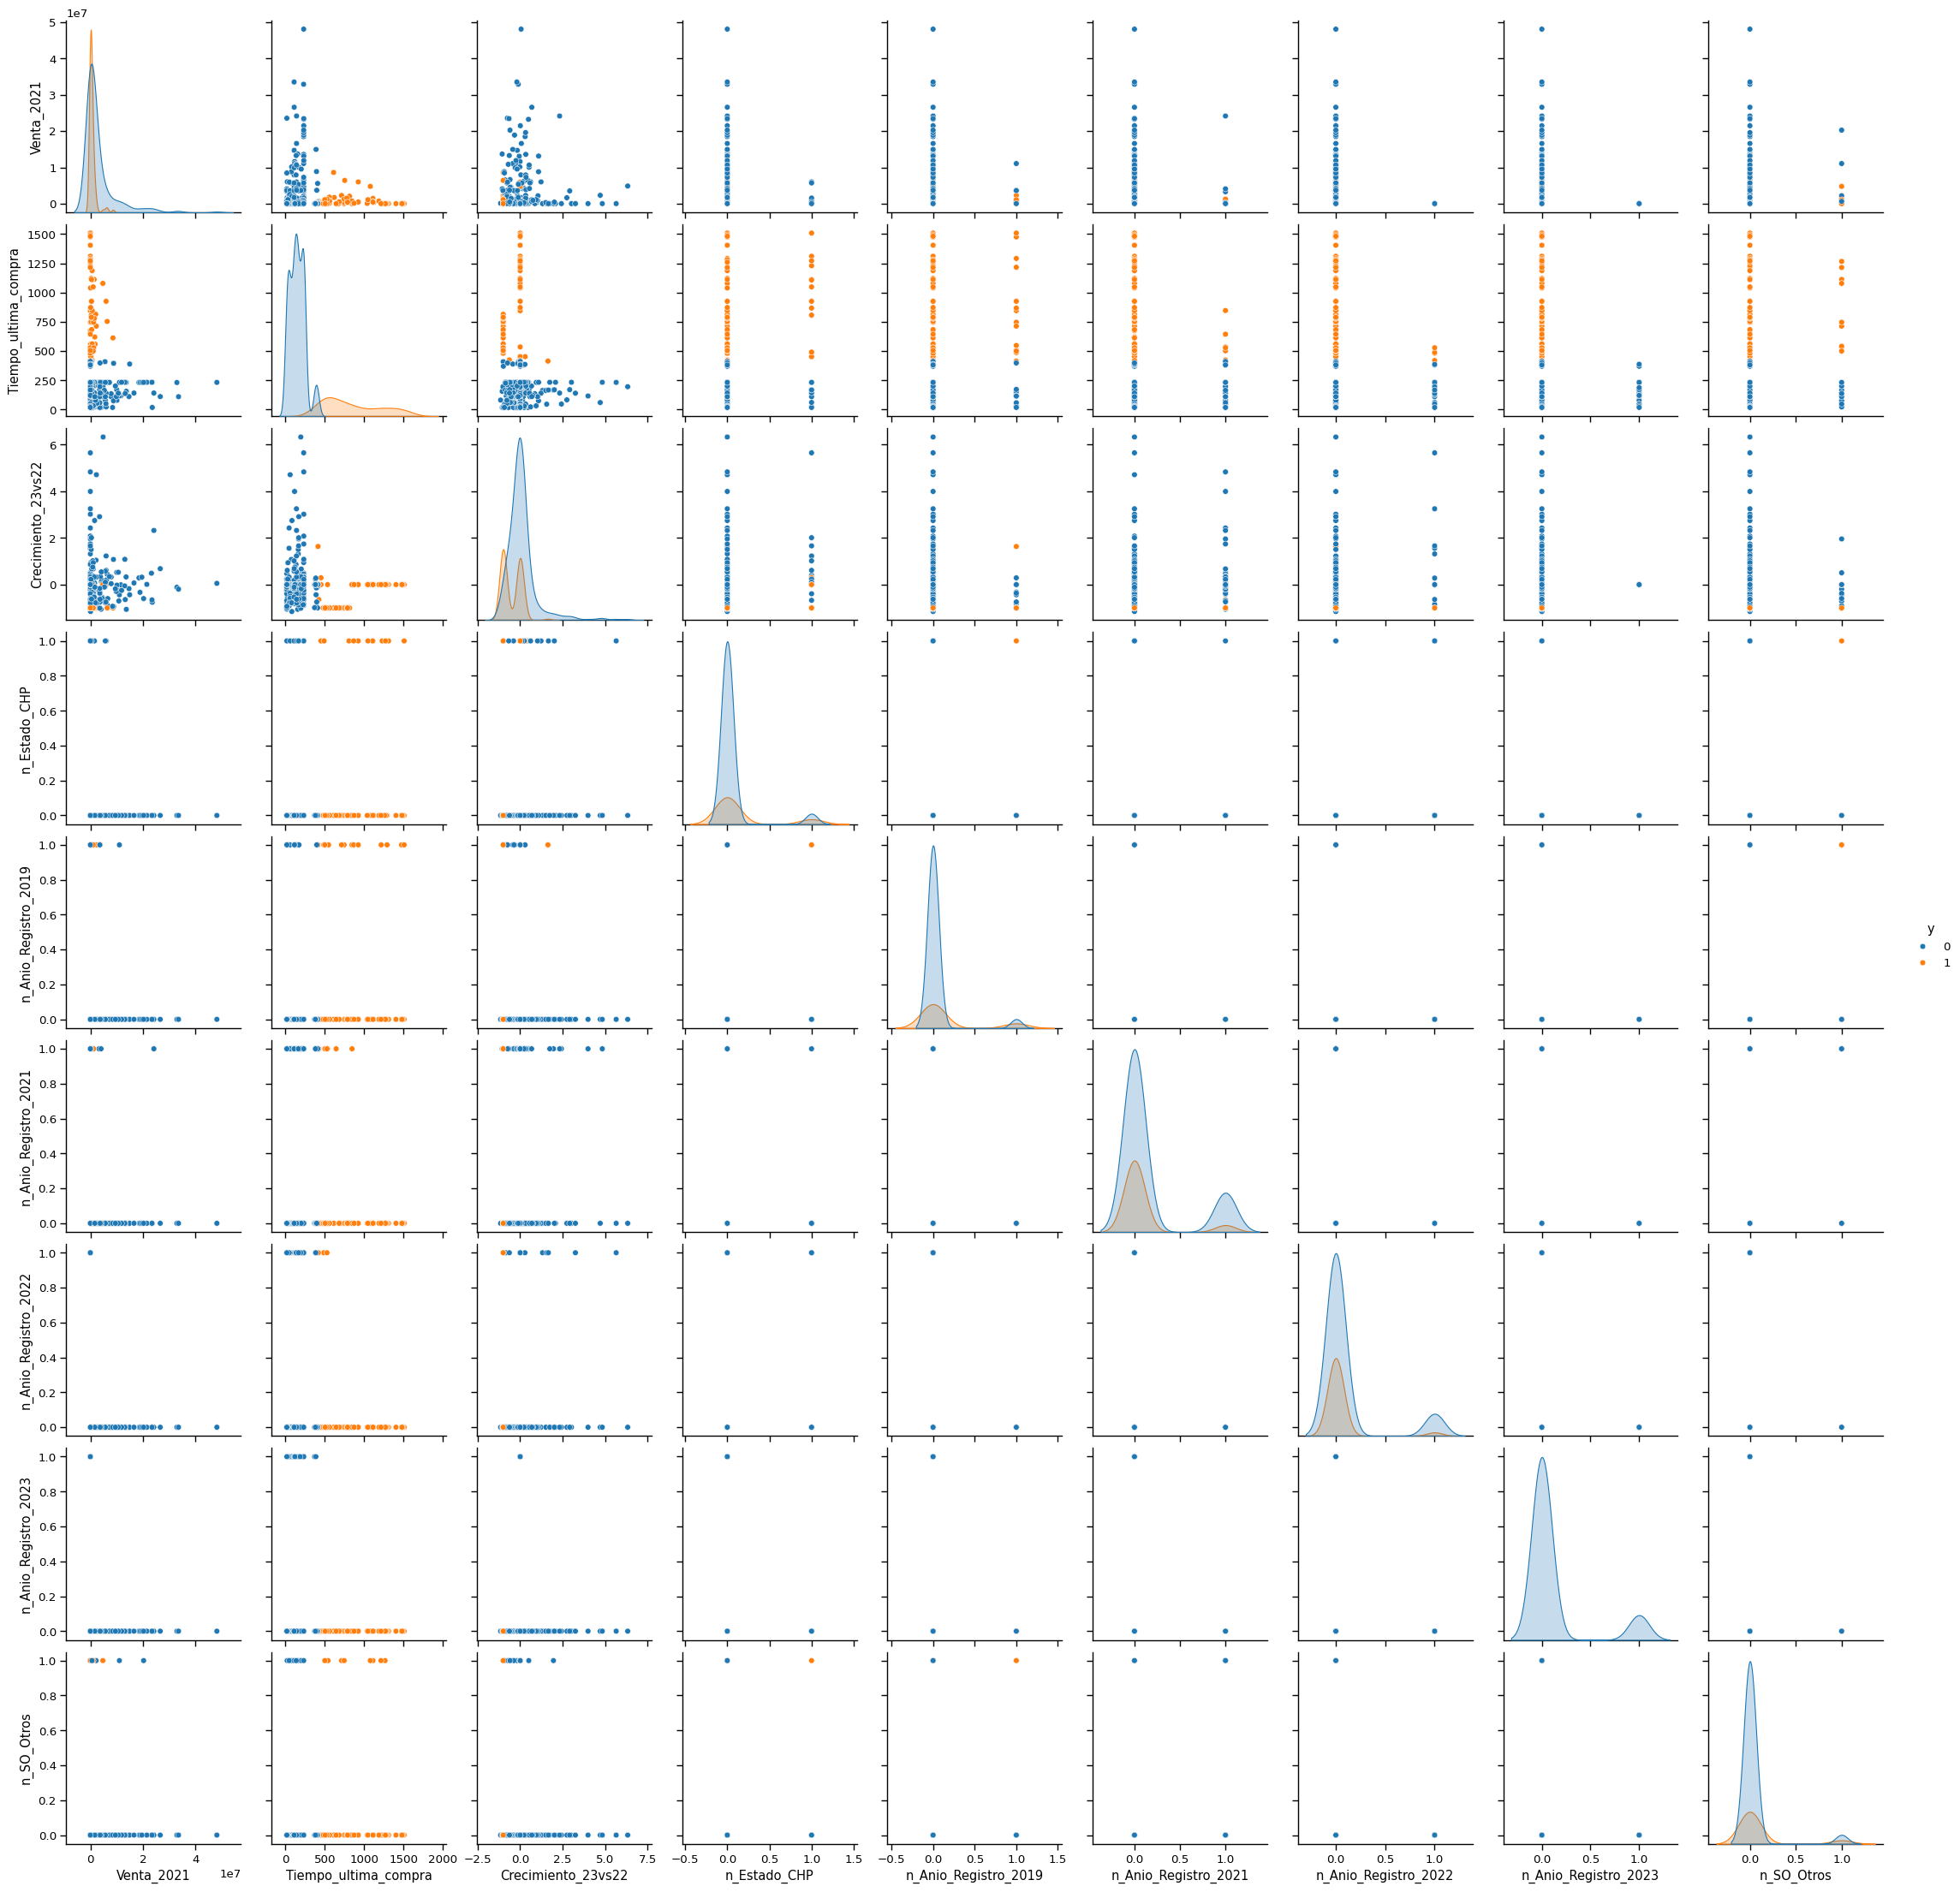

In [68]:
sns.pairplot(data=train[best+['y']],hue='y')

# Aprendizaje
## Regresión Logistica.

In [69]:
lr = LogisticRegression() # Utilizar el solver 'saga' en lugar de 'lbfgs'

### Híper-parametrización

In [70]:
hiper_param = {'penalty':['l1', 'l2', 'elasticnet', None],'C':np.arange(0.1,2,0.1)}

In [71]:
reduce(lambda x,y:x*y,map(len,hiper_param.values()))  # Ejemplo de ponderación para la clase 1

76

GridSearchCV es una técnica de validación cruzada incluida en el paquete de scikit learn. Lo que hace es ejecutarse a través de los diferentes parámetros que se introducen en la cuadrícula de parámetros y extraer los mejores valores y combinaciones de parámetros

In [72]:
grid = GridSearchCV(param_grid=hiper_param, n_jobs=-1,
                    estimator=lr, cv=5, verbose=True, scoring='roc_auc')

In [73]:
grid.fit(train[best],train['y'])

Fitting 5 folds for each of 76 candidates, totalling 380 fits


c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


190 fits failed out of a total of 380.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carlo\App

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring='roc_auc', verbose=True)

In [74]:
lr = grid.best_estimator_
lr

LogisticRegression(C=0.1)

In [75]:
grid.best_score_

0.9295101389838232

### Parámetros $\vec{\theta},\theta_0$

In [76]:
lr.fit(train[best],train['y'])

LogisticRegression(C=0.1)

In [77]:
lr.coef_,lr.intercept_

(array([[-6.68769205e-07,  1.94547592e-03, -2.72925157e-06,
          1.34862368e-07,  2.53980345e-07, -1.27070748e-06,
         -8.91263441e-07, -1.13121814e-06,  5.68462062e-08]]),
 array([-3.32361324e-06]))

## K Nearest Neighbors

In [78]:
knn = KNeighborsClassifier()

#### Hiper-Parametrización.

In [79]:
hiper_param = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}

In [80]:
class_weight = [{0: 1, 1: w} for w in [1, 2, 5]]

In [81]:
# reduce(lambda x,y:x*y,map(len,hiper_param.values()))
total_combinations = reduce(lambda x, y: x * y, [len(values) for values in hiper_param.values()]) * len(class_weight)

In [82]:
grid = GridSearchCV(param_grid=hiper_param, n_jobs=-1, estimator=knn, cv=5, verbose=True, scoring='roc_auc')

# grid = GridSearchCV(knn, hiper_param, cv=5)

In [83]:
# Ajustar el modelo con diferentes combinaciones de hiperparámetros y ponderaciones
for weights in class_weight:
    knn.set_params(weights=weights)
    grid.fit(train[best], train['y'])

# grid.fit(train[best], train['y'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [84]:
knn = grid.best_estimator_
knn

KNeighborsClassifier(n_neighbors=9)

In [85]:
grid.best_score_

0.8938355358092199

#### Parámetros || ||, $K_0$

In [86]:
knn.fit(train[best],train['y'])

KNeighborsClassifier(n_neighbors=9)

In [87]:
knn.kneighbors_graph

<bound method KNeighborsMixin.kneighbors_graph of KNeighborsClassifier(n_neighbors=9)>

## Sopport Vector Machine

In [88]:
# cfl_SVM = svm.SVC()

#### Híper-parametrización

In [89]:
# param_SVM = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 0.5, 1]}

In [90]:
# reduce(lambda x,y:x*y,map(len,param_SVM.values()))

In [91]:
# grid_SVM = GridSearchCV(cfl_SVM, param_SVM, cv=5,  n_jobs=-1, scoring='roc_auc', verbose=True)

In [92]:
# grid_SVM.fit(train[best], train['y'])

#### Parámetros $\vec{\gamma},\gamma_0$

In [93]:
# cfl_SVM = grid_SVM.best_estimator_
# cfl_SVM

In [94]:
# grid_SVM.best_score_

## Random Forest

In [95]:
rf = RandomForestClassifier(random_state=1, oob_score=True)

#### Híper-parametrización

In [96]:
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', 'None']
}

In [97]:
reduce(lambda x,y:x*y,map(len,param_rf.values()))

324

In [98]:
grid_rf = GridSearchCV(rf, param_rf, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(train[best], train['y'])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


810 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ba

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2', 'None'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)

#### Parámetros.

In [99]:
rf = grid_rf.best_estimator_
rf

RandomForestClassifier(oob_score=True, random_state=1)

In [100]:
grid_rf.best_score_

1.0

In [101]:
grid_rf.best_estimator_

RandomForestClassifier(oob_score=True, random_state=1)

## Multi-layer Perceptron classifier.

In [102]:
mlp = MLPClassifier(random_state=37)

#### Híper-parametrización

In [103]:
# Definir los posibles valores de los hiperparámetros
param_mlp = {
    'hidden_layer_sizes': [(100,), (50,50), (100,50)],
    'activation': ['logistic', 'relu'],
    'solver': ['lbfgs', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
}

In [104]:
reduce(lambda x,y:x*y,map(len,param_mlp.values()))

108

In [105]:
# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(mlp, param_mlp, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(train[best], train['y'])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



GridSearchCV(cv=5, estimator=MLPClassifier(random_state=37), n_jobs=-1,
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
                         'learning_rate': ['constant', 'adaptive',
                                           'invscaling'],
                         'solver': ['lbfgs', 'sgd']},
             scoring='roc_auc', verbose=1)

#### Parámetros.

In [106]:
best_params = grid_search.best_params_
best_params

{'activation': 'logistic',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'solver': 'lbfgs'}

In [107]:
# Crear un nuevo clasificador utilizando los mejores hiperparámetros
mlp = MLPClassifier(random_state=42, **best_params)

In [108]:
mlp.fit(train[best], train['y'])

c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



MLPClassifier(activation='logistic', random_state=42, solver='lbfgs')

# Métricas de ajuste

In [109]:
for v, mapa in mapa_norm:
    valid[f'n_{v}'] = valid[v].replace(mapa)

In [110]:
print(valid)

           ID  y  Antiguedad    Volumen     Consumo  Ship_to  Frec  \
0    21108383  0        2340  16723.050  2408771.73        1    12   
1    21338131  1        1470    -73.800    34738.54        1     4   
2    21523355  0         560   4584.200  1657595.71        1    69   
3    21372909  0        1464   3371.944  7884330.40        1    74   
4    21501025  0         989   8917.900  3693182.12        1   297   
..        ... ..         ...        ...         ...      ...   ...   
163  21428173  1        1153   4303.680   880140.50        1    59   
164  21108985  0        2340   1236.000   978839.09        2     6   
165  21487379  1        1019   1391.000   333621.32        1     2   
166  21218674  1        2049   4541.140  2452378.51        1    45   
167  21320909  1        1578     87.000   307481.26        1     1   

     Tiempo_ultima_compra  Devolucion  Venta_2020  Venta_2021  Venta_2022  \
0                     137           0  1565532.79        0.00        0.00   
1    

In [111]:
valid[var_dummy] = oh.transform(valid[varn])

c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning:

Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros



Metricas para la regresión logistica.

In [112]:
train['y^_lr'] = lr.predict(train[best])
valid['y^_lr'] = lr.predict(valid[best])

train['proba_lr'] = lr.predict_proba(train[best])[:,1]
valid['proba_lr'] = lr.predict_proba(valid[best])[:,1]

<Axes: title={'center': 'Curva ROC - Modelo de Regresión Logística (Valid)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

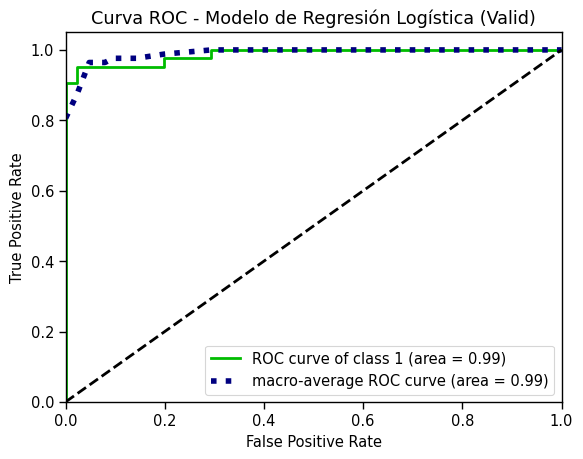

In [113]:
plot_roc(y_probas=lr.predict_proba(
    train[best]), y_true=train['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - Modelo de Regresión Logística (Train)'
)


plot_roc(y_probas=lr.predict_proba(
    valid[best]), y_true=valid['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - Modelo de Regresión Logística (Valid)'
)


In [114]:
accuracy_score(y_true=valid['y'],y_pred=valid['proba_lr']>0.4)

0.5238095238095238

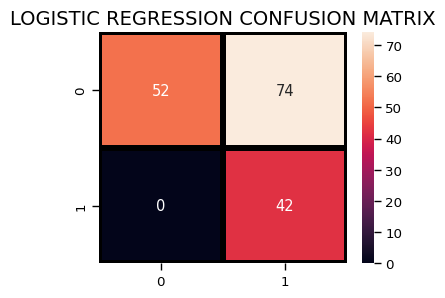

In [115]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_true=valid['y'],y_pred=valid['y^_lr']),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
# pd.DataFrame(confusion_matrix(y_true=valid['y'],y_pred=valid['y^']))
plt.title("LOGISTIC REGRESSION CONFUSION MATRIX",fontsize=14)
plt.show()

Metricas para K Nearest Neighbors

In [116]:
train['y^_knn'] = knn.predict(train[best])
valid['y^_knn'] = knn.predict(valid[best])

train['proba_knn'] = knn.predict_proba(train[best])[:,1]
valid['proba_knn'] = knn.predict_proba(valid[best])[:,1]

<Axes: title={'center': 'Curva ROC - K Nearest Neighbors (Valid)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

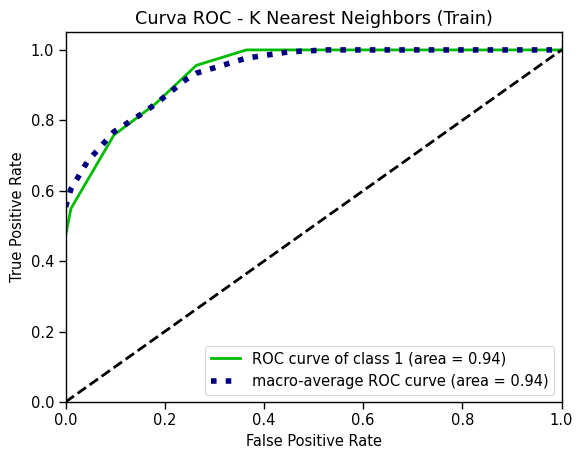

In [117]:
plot_roc(y_probas=knn.predict_proba(
    train[best]), y_true=train['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - K Nearest Neighbors (Train)'
)


plot_roc(y_probas=knn.predict_proba(
    valid[best]), y_true=valid['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - K Nearest Neighbors (Valid)'
)


In [118]:
accuracy_score(y_true=valid['y'],y_pred=valid['proba_knn']>0.4)

0.8392857142857143

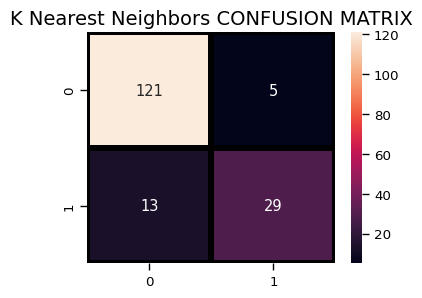

In [119]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_true=valid['y'],y_pred=valid['y^_knn']),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
# pd.DataFrame(confusion_matrix(y_true=valid['y'],y_pred=valid['y^']))
plt.title("K Nearest Neighbors CONFUSION MATRIX",fontsize=14)
plt.show()

Metricas para la Sopport Vector Machine

Las maquinas de soporte vectorial no estiman probabilidades.

In [120]:
# train['y^_SVM'] = cfl_SVM.predict(train[best])
# valid['y^_SVM'] = cfl_SVM.predict(valid[best])

In [121]:
# print(classification_report(valid['y'], valid['y^_SVM']))

Metricas para Random Forest

In [122]:
train['y^_rf'] = rf.predict(train[best])
valid['y^_rf'] = rf.predict(valid[best])

train['proba_rf'] = rf.predict_proba(train[best])[:,1]
valid['proba_rf'] = rf.predict_proba(valid[best])[:,1]

<Axes: title={'center': 'Curva ROC - Random Forest (Valid)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

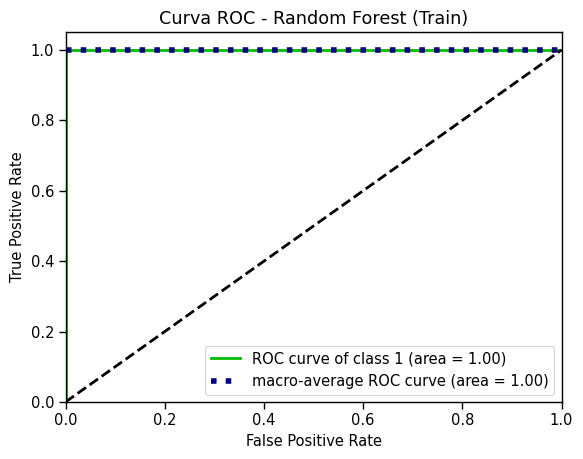

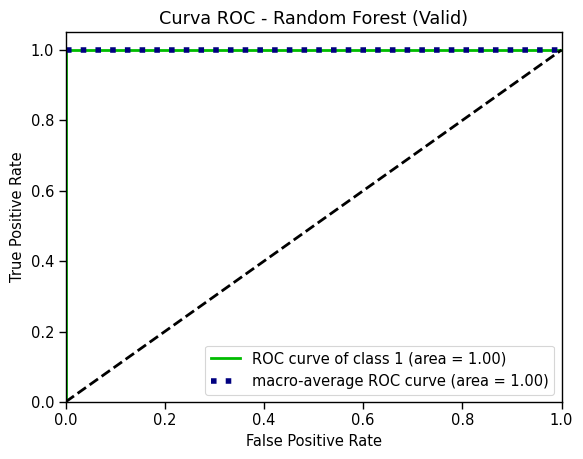

In [123]:
plot_roc(y_probas=rf.predict_proba(
    train[best]), y_true=train['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - Random Forest (Train)'
)


plot_roc(y_probas=rf.predict_proba(
    valid[best]), y_true=valid['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - Random Forest (Valid)'
)


In [124]:
accuracy_score(y_true=valid['y'],y_pred=valid['proba_rf']>0.4)

1.0

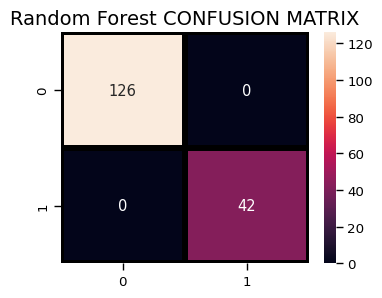

In [125]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_true=valid['y'],y_pred=valid['y^_rf']),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
# pd.DataFrame(confusion_matrix(y_true=valid['y'],y_pred=valid['y^']))
plt.title("Random Forest CONFUSION MATRIX",fontsize=14)
plt.show()

Metricas para Multi-layer Perceptron classifier.

In [126]:
# Predecir las etiquetas y las probabilidades en el conjunto de entrenamiento
train['y^_MLP'] = mlp.predict(train[best])
train['proba_MLP'] = mlp.predict_proba(train[best])[:, 1]

# Predecir las etiquetas y las probabilidades en el conjunto de validación
valid['y^_MLP'] = mlp.predict(valid[best])
valid['proba_MLP'] = mlp.predict_proba(valid[best])[:, 1]


<Axes: title={'center': 'Curva ROC - Multi-layer Perceptron classifier (Valid)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

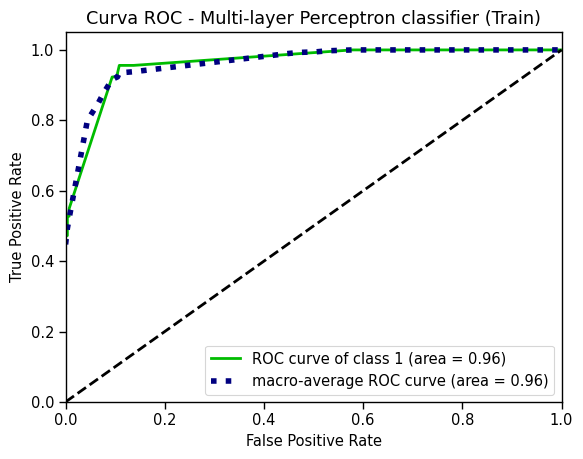

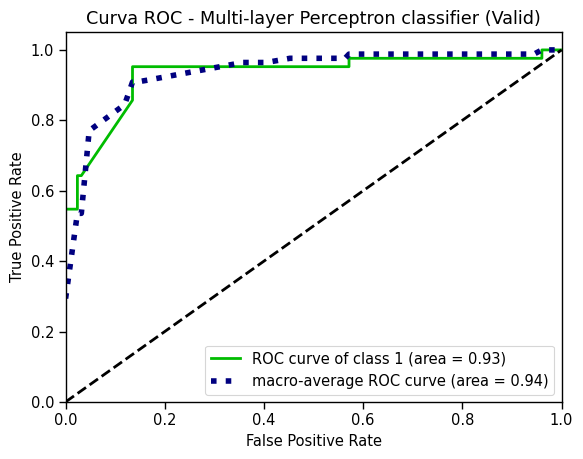

In [127]:
plot_roc(y_probas=mlp.predict_proba(
    train[best]), y_true=train['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - Multi-layer Perceptron classifier (Train)'
)


plot_roc(y_probas=mlp.predict_proba(
    valid[best]), y_true=valid['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - Multi-layer Perceptron classifier (Valid)'
)


In [128]:
accuracy_score(y_true=valid['y'],y_pred=valid['proba_MLP']>0.4)

0.8869047619047619

In [129]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_true=valid['y'],y_pred=valid['y^_MLP']),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
# pd.DataFrame(confusion_matrix(y_true=valid['y'],y_pred=valid['y^']))
plt.title("Multi-layer Perceptron classifier CONFUSION MATRIX",fontsize=14)
plt.show()

In [130]:
best

['Venta_2021',
 'Tiempo_ultima_compra',
 'Crecimiento_23vs22',
 'n_Estado_CHP',
 'n_Anio_Registro_2019',
 'n_Anio_Registro_2021',
 'n_Anio_Registro_2022',
 'n_Anio_Registro_2023',
 'n_SO_Otros']

In [131]:
train[['Frec','y']].groupby('y').mean()

Frec
y            
0  115.194946
1   19.219780

In [132]:
# lr.predict_proba(np.array([1,1,0,0,1,1]).reshape(1,-1))

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Predecir las etiquetas y las probabilidades en el conjunto de entrenamiento
train['y^_MLP'] = mlp.predict(train[best])
train['proba_MLP'] = mlp.predict_proba(train[best])[:, 1]

# Predecir las etiquetas y las probabilidades en el conjunto de validación
valid['y^_MLP'] = mlp.predict(valid[best])
valid['proba_MLP'] = mlp.predict_proba(valid[best])[:, 1]

# Obtener los coeficientes o importancias de las características
feature_importance = np.abs(mlp.coefs_[0]).sum(axis=1)

# Crear una gráfica de barras para mostrar la importancia de características
plt.figure(figsize=(10, 6))
plt.bar(range(len(best)), feature_importance, tick_label=best)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de Características en el Modelo MLP')
plt.tight_layout()
plt.show()


C:\Users\carlo\AppData\Local\Temp\ipykernel_26828\3320350770.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='proba_knn', ylabel='Density'>

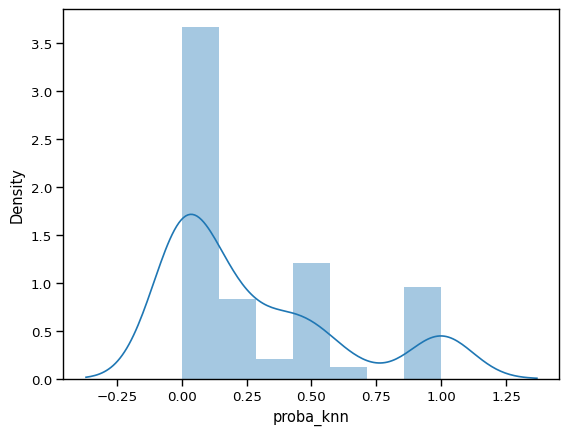

In [134]:
sns.distplot(valid['proba_knn'])

In [135]:
# center = np.mean(valid['proba_knn'], axis=0)
# slope = -valid['proba_knn'].scalings_[0]/valid['proba_knn'].scalings_[1]

C:\Users\carlo\AppData\Local\Temp\ipykernel_26828\2460202917.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='proba_rf', ylabel='Density'>

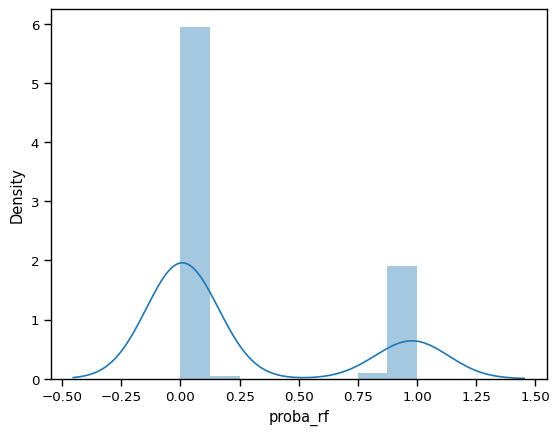

In [136]:
sns.distplot(valid['proba_rf'])

C:\Users\carlo\AppData\Local\Temp\ipykernel_26828\2502877691.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='proba_MLP', ylabel='Density'>

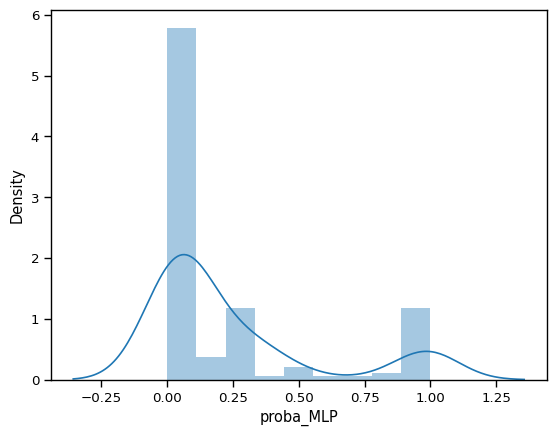

In [137]:
sns.distplot(valid['proba_MLP'])

C:\Users\carlo\AppData\Local\Temp\ipykernel_26828\1176816150.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='proba_lr', ylabel='Density'>

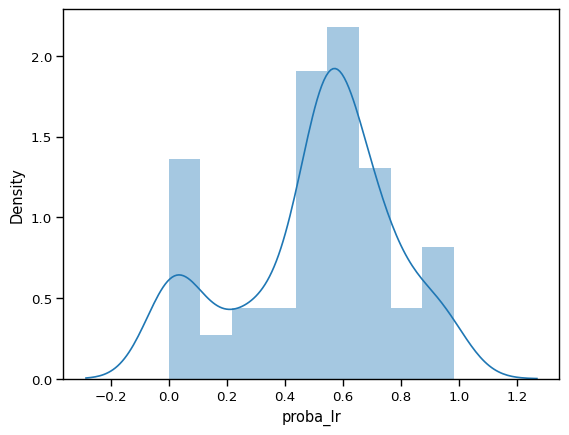

In [138]:
sns.distplot(valid['proba_lr'])

# Eligiendo el modelo Final.

In [139]:
from sklearn.ensemble import VotingClassifier
clf1 = KNeighborsClassifier()
clf2 = LogisticRegression()
clf3 = RandomForestClassifier()
clf4 = MLPClassifier()
eclf1 = VotingClassifier(estimators=[('knn', clf1), ('lr', clf2), ('rf', clf3), ('mlp', clf4)], voting='soft')
eclf1.fit(train[best], train['y'])
predictions = eclf1.predict(valid[best])
print("Final Accuracy Score ")
print(accuracy_score(valid['y'], predictions))

Final Accuracy Score 
0.9464285714285714


In [140]:
train['y^_last'] = eclf1.predict(train[best])
valid['y^_last'] = eclf1.predict(valid[best])

train['proba_last'] = eclf1.predict_proba(train[best])[:,1]
valid['proba_last'] = eclf1.predict_proba(valid[best])[:,1]

In [141]:
print(classification_report(valid['y'], predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       126
           1       0.92      0.86      0.89        42

    accuracy                           0.95       168
   macro avg       0.94      0.92      0.93       168
weighted avg       0.95      0.95      0.95       168



<Axes: title={'center': 'Curva ROC - Best Model (Valid)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

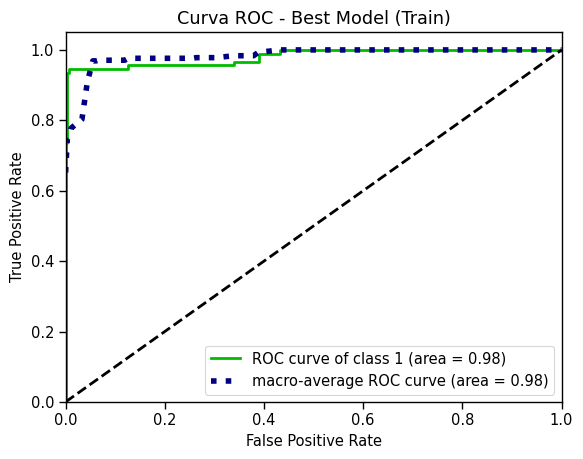

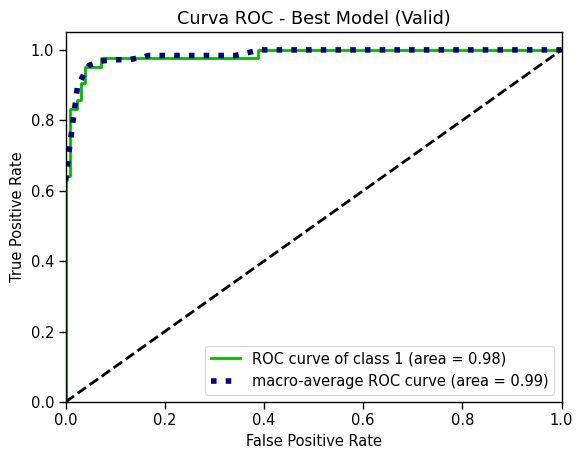

In [142]:
plot_roc(y_probas=eclf1.predict_proba(
    train[best]), y_true=train['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - Best Model (Train)'
)


plot_roc(y_probas=eclf1.predict_proba(
    valid[best]), y_true=valid['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1],
    title='Curva ROC - Best Model (Valid)'
)


In [143]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(valid['y'], valid['y^_last']),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("FINAL CONFUSION MATRIX",fontsize=14)
plt.show()

In [145]:
Predicciones = pd.concat([train, valid], axis=0)

In [149]:
Predicciones.groupby('ID')['Devolucion'].mean().reset_index()

ID  Devolucion
0    21107235         1.0
1    21107240         2.0
2    21107243         1.0
3    21107250         0.0
4    21107252         1.0
..        ...         ...
531  26041016         0.0
532  26041032         0.0
533  26045516         0.0
534  26045521         0.0
535  26085323         0.0

[536 rows x 2 columns]

In [150]:
Predicciones=Predicciones[['ID', 'y','Antiguedad' , 'Tiempo_ultima_compra' ,'Compra_unica','Temporada','y^_lr', 'proba_lr','y^_knn','proba_knn','y^_rf','proba_rf', 'y^_MLP', 'proba_MLP',	'y^_last',	'proba_last']]
Predicciones

ID  y  Antiguedad  Tiempo_ultima_compra  Compra_unica Temporada  \
0    21352679  0        1334                    18         False        OI   
1    21107556  0        2340                   111         False        OI   
2    21247649  1        2061                   925         False        OI   
3    21481879  0        1056                   224         False        OI   
4    21216509  0        2081                    18         False        OI   
..        ... ..         ...                   ...           ...       ...   
163  21428173  1        1153                   480         False        OI   
164  21108985  0        2340                   142         False        OI   
165  21487379  1        1019                   529         False        OI   
166  21218674  1        2049                  1078         False        OI   
167  21320909  1        1578                  1536         False        OI   

     y^_lr      proba_lr  y^_knn  proba_knn  y^_rf  proba_rf  y^_MLP  \
0        0  4.747644e-01       0   0.333333      0      0.00       0   
1        0  6.653871e-05       0   0.000000      0      0.00       0   
2        0  9.928183e-02       0   0.111111      1      0.95       0   
3        1  6.072535e-01       0   0.000000      0      0.00       0   
4        0  1.481434e-07       0   0.000000      0      0.00       0   
..     ...           ...     ...        ...    ...       ...     ...   
163      1  7.178510e-01       1   1.000000      1      0.96       1   
164      1  5.414390e-01       0   0.444444      0      0.01       0   
165      1  7.367520e-01       1   1.000000      1      0.97       1   
166      1  8.740859e-01       0   0.222222      1      0.98       0   
167      1  9.520404e-01       1   1.000000      1      0.98       1   

     proba_MLP  y^_last    proba_last  
0     0.110137        0  1.686911e-01  
1     0.110137        0  1.663462e-05  
2     0.110137        0  3.098205e-01  
3     0.000012        0  4.007652e-01  
4     0.110137        0  3.703564e-08  
..         ...      ...           ...  
163   0.929404        1  9.194604e-01  
164   0.330796        0  2.853598e-01  
165   0.979618        1  9.241873e-01  
166   0.207988        0  4.635215e-01  
167   0.999989        1  9.780101e-01  

[536 rows x 16 columns]

Exportamos los resultados:

In [151]:
# Predicciones.to_excel('C:\\Users\\carlo\\OneDrive\\Documents\\Python Scripts Last Version\\Analytics\\Beta v2.0\\Output\\Churn_Prediction.xlsx', index=False)
Predicciones.to_csv("./Output/Churn_Prediction.csv", index=False)